# Weather Analysis
This notebook analyzes Indego bike share use in Phialadelphia and the effects that weather has on ridership to determine how much of an increase in bike sharing the city is seeing.

Bike share data for this note book can be found here: https://www.rideindego.com/about/data/
Weather data can be found here: https://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression

from packages.data import get_bike_data
from packages.daylight import hours_of_daylight

### Getting the data
Uploads the Indego .csv files and formats the data to be used for analysis

In [2]:
data = get_bike_data()

In [3]:
#creates date and hour columns
ind = pd.DatetimeIndex(data.start_time)
data['date'] = ind.date.astype('datetime64')
data['hour'] = ind.hour

#indexing the data using date
indexed_data = data.set_index('date', drop = False)
                              
#resmaples the data to get it in daily and weekly views
daily = indexed_data.resample('d').sum()
daily['count'] = daily['count'].fillna(value = 0)
daily['duration'] = daily['duration'].fillna(value = 0)
                              
weekly = daily.resample('w').sum()  

In [4]:
#manually adds number of Indego stations available at a given date (couldn't figure out easier way)
daily['num_stations'] = 120
daily['num_stations'][daily.index < '2017-06-09'] = 118
daily['num_stations'][daily.index < '2017-06-08'] = 115
daily['num_stations'][daily.index < '2017-06-07'] = 112
daily['num_stations'][daily.index < '2017-06-06'] = 109
daily['num_stations'][daily.index < '2017-06-05'] = 107
daily['num_stations'][daily.index < '2016-05-24'] = 106
daily['num_stations'][daily.index < '2016-05-06'] = 104
daily['num_stations'][daily.index < '2016-05-05'] = 100
daily['num_stations'][daily.index < '2016-05-04'] = 96
daily['num_stations'][daily.index < '2016-05-03'] = 92
daily['num_stations'][daily.index < '2016-05-02'] = 88
daily['num_stations'][daily.index < '2016-04-29'] = 86
daily['num_stations'][daily.index < '2016-04-28'] = 84
daily['num_stations'][daily.index < '2016-04-27'] = 82
daily['num_stations'][daily.index < '2016-04-26'] = 80
daily['num_stations'][daily.index < '2016-04-25'] = 78
daily['num_stations'][daily.index < '2016-04-15'] = 77
daily['num_stations'][daily.index < '2016-04-08'] = 76
daily['num_stations'][daily.index < '2016-03-31'] = 75
daily['num_stations'][daily.index < '2015-10-20'] = 74
daily['num_stations'][daily.index < '2015-07-31'] = 73
daily['num_stations'][daily.index < '2015-06-10'] = 72
daily['num_stations'][daily.index < '2015-04-29'] = 67
daily['num_stations'][daily.index < '2015-04-28'] = 62

/Users/brandonkalnasy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/brandonkalnasy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/brandonkalnasy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

### Bike Share Use Over Time

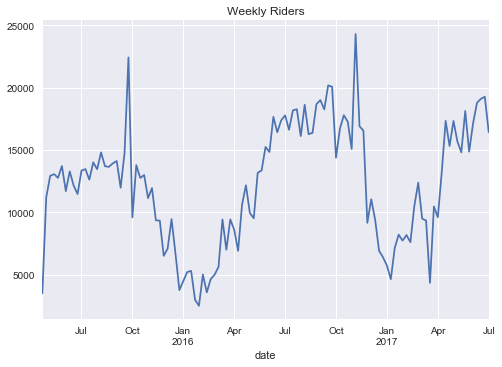

In [5]:
weekly['count'].plot()
plt.title('Weekly Riders');

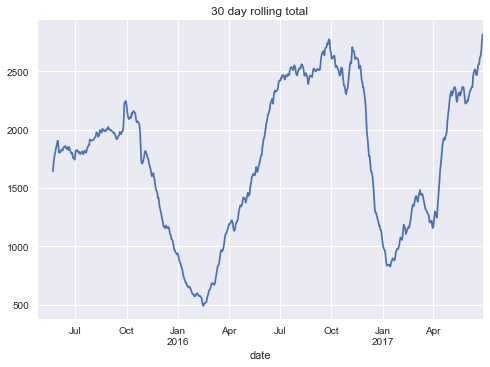

In [6]:
daily['count'].rolling(window = 30).mean().plot()
plt.title('30 day rolling total');

- The sharp increase in Fall 2015 is from the week the Pope visited Philadelphia. Car traffic in the city was haulted for a few days leaving empty streets for cyclists to ride in.
- Slight increase in Fall 2016 is from the SEPTA worker strike, which shutdown public transportation for ~1 week
- As expected there is higher use in warmer months compared to colder ones. Let's look at how much weather is actually affecting ridership below.

### Hours of Daylight
With summer having so much more daylight than winter, I looked at how the hours of daylight affects the increase in riders in the summer months.

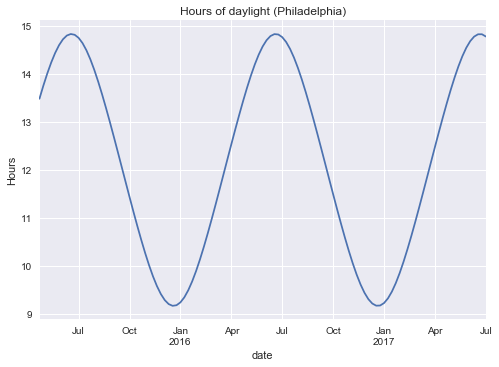

In [7]:
#maps the hours_of_daylight function with the dates
weekly['daylight']=list(map(hours_of_daylight, weekly.index))
daily['daylight'] = list(map(hours_of_daylight, daily.index))

# Plot the daylight curve
weekly['daylight'].plot()
plt.title('Hours of daylight (Philadelphia)')
plt.ylabel('Hours');

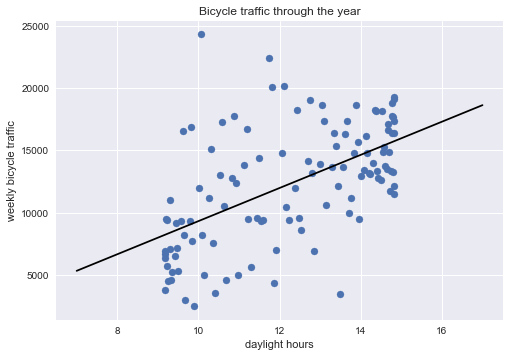

In [8]:
#creates linear model to predict number of riders from hours of daylight
X = weekly[['daylight']]
y = weekly['count']
clf = LinearRegression(fit_intercept=True).fit(X, y)

xfit = np.linspace(7, 17)
yfit = clf.predict(xfit[:, None])
plt.scatter(weekly['daylight'], weekly['count'])
plt.plot(xfit, yfit, '-k')
plt.title("Bicycle traffic through the year")
plt.xlabel('daylight hours')
plt.ylabel('weekly bicycle traffic');

In [9]:
print('For every extra hour of sunlight, the expected increase in weekly riders is: ' + str(clf.coef_[0]))

For every extra hour of sunlight, the expected increase in weekly riders is: 1328.01399997


There's a trend that more daylight increases ridership, however the wide spread of the scatter plot suggests that other factors are in effect. Since hours of daylight correlates with the temperature and precipitation, I will look at how those factors affect the trend later.

Now I plot the number of weekly riders along the daylight trend. 

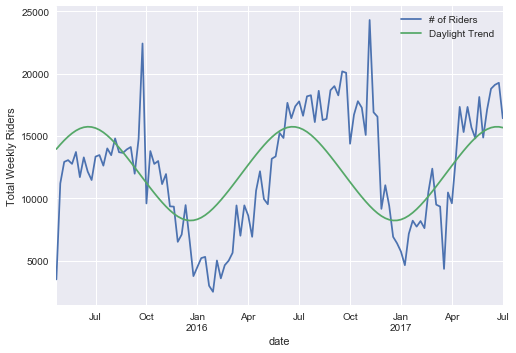

In [10]:
weekly['daylight_trend'] = clf.predict(X)

weekly[['count', 'daylight_trend']].plot()
plt.legend(['# of Riders', 'Daylight Trend'])
plt.ylabel("Total Weekly Riders");

The shape of the actual riders plot is similar to the daylight trend but it has more extreme peaks and valleys. This sugests that there are other factors in effect.

Below, I 'de-trend' the data by subtracting the trend from the total and replacing it with its mean. This removes the factors in the data that correlate with hour of daylight. This gives us a view of the data if daylight were not a factor so we can see how the ridership is changing over time corrected for hours of daylight.

root-mean-square about trend: 3981 riders


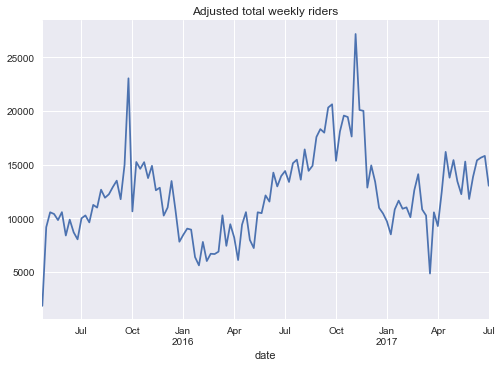

In [11]:
#similar to above, I subtract the hours of daylight trend and replace it with the mean
weekly['daylight_corrected_total'] = weekly['count'] - weekly['daylight_trend'] + weekly['daylight_trend'].mean()

weekly['daylight_corrected_total'].plot()
plt.title("Adjusted total weekly riders")

rms = np.std(weekly['daylight_corrected_total'])
print("root-mean-square about trend: {0:.0f} riders".format(rms));

### Day of the Week
This is looks at the ridership trends based on the day of the week

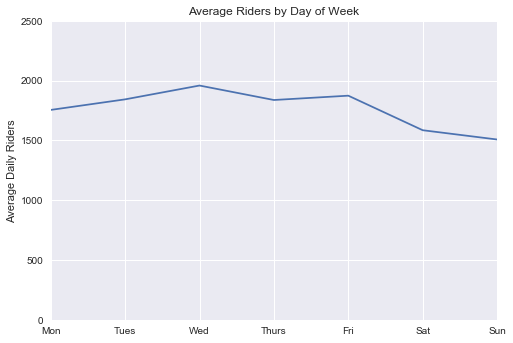

In [12]:
#adding days of week to daily data
days = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
daily['dayofweek'] = daily['count'].index.dayofweek

#creates grouped data by day of week and plots average daily riders 
grouped = daily.groupby('dayofweek')['count'].mean()
grouped.index = days
grouped.plot()
plt.title('Average Riders by Day of Week')
plt.ylabel('Average Daily Riders')
plt.ylim(0, 2500);

#not showing too much of drop between weekdays and weekends

Let's look at how the day of the week affects ridership 

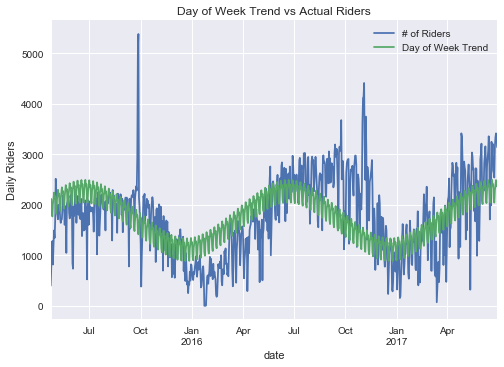

In [13]:
# Add one-hot indicators of days of the week
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

#trend data from days of the week and daylight together
X = daily[days + ['daylight']]
y = daily['count']
clf = LinearRegression().fit(X, y)

#plots the daylight/day of week trend next to the daily rider count
daily['dayofweek_trend'] = clf.predict(X)
daily[['count', 'dayofweek_trend']].plot()
plt.ylabel('Daily Riders')
plt.title('Day of Week Trend vs Actual Riders')
plt.legend(['# of Riders', 'Day of Week Trend']);


I'm going to 'de-trend' the data again by subtracting the day of week and daylight trend from the total and replacing it with the mean. The plot below shows the trend in riders corrected for day of week and hours of daylight.

rms = 668


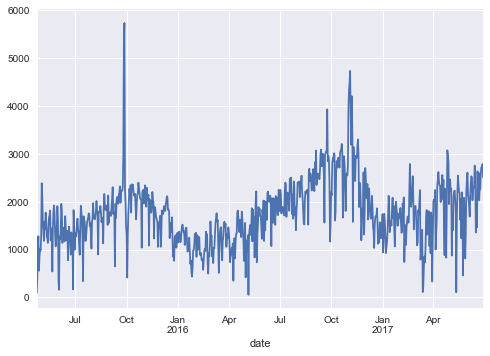

In [14]:
daily['dayofweek_corrected'] = (daily['count'] - daily['dayofweek_trend'] + daily['dayofweek_trend'].mean())
daily['dayofweek_corrected'].plot()
print("rms = {0:.0f}".format(np.std(daily['dayofweek_corrected'])));

### Weather effects on ridership
Now let's look at how the temperature and amount of precipitation affects ridership.

In [15]:
#Reads the weather data
weather = pd.read_csv('phlweather.csv', index_col='DATE', parse_dates=True, usecols=[2, 3, 4, 8, 9, 10])
#drops the dates after 2017Q2 since there is only bike data through this quarter
weather = weather[:'2017-06-30']

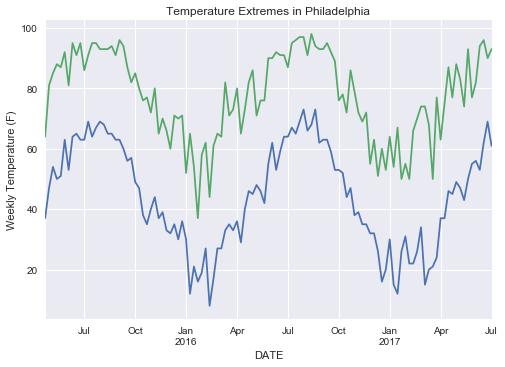

In [16]:
#plots min and max weekly temps
weather['TMIN'].resample('w').min().plot()
weather['TMAX'].resample('w').max().plot()
plt.ylabel('Weekly Temperature (F)');
plt.title('Temperature Extremes in Philadelphia');


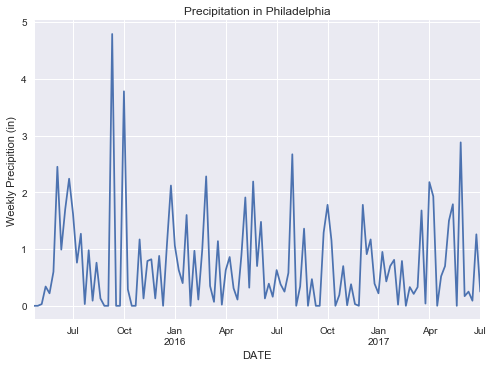

In [17]:
#plots weekly precipitation 
weather['PRCP'].resample('w').sum().plot()
plt.ylabel('Weekly Precipition (in)')
plt.title('Precipitation in Philadelphia');

In [18]:
# join the weather data to daily data
daily = daily.join(weather)

Now let's add the weather data into the linear model and plot the trend along the total rider count.

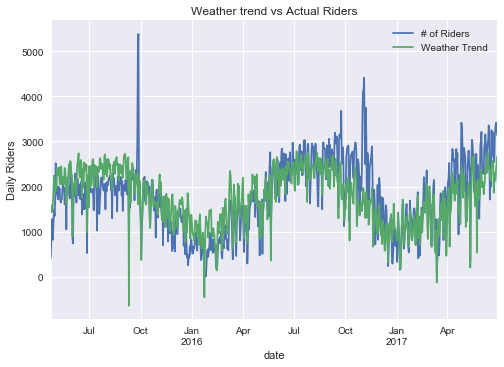

In [19]:
columns = days + ['daylight', 'AWND', 'TMIN', 'TMAX', 'PRCP']

#creates linear model using day of week and weather factors to predict number of riders
X = daily[columns]
y = daily['count']
clf = LinearRegression().fit(X, y)
daily['weather_trend'] = clf.predict(X)

# Plot the overall trend
daily[['count', 'weather_trend']].plot()
plt.title('Weather trend vs Actual Riders')
plt.legend(['# of Riders', 'Weather Trend'])
plt.ylabel('Daily Riders');

Now let's de-trend the data again and plot it

rms = 525


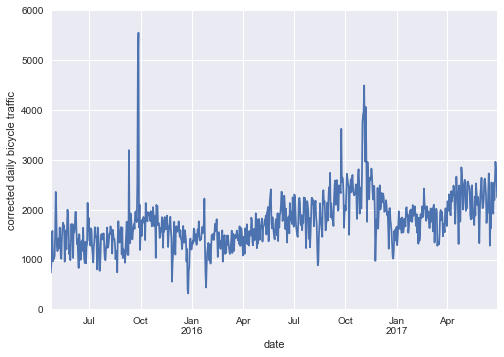

In [20]:
#subtracts trend from count and replaces with mean

daily['weather_corrected'] = daily['count'] - daily['weather_trend'] + daily['weather_trend'].mean()
print("rms = {0:.0f}".format(np.std(daily['weather_corrected'])))
daily['weather_corrected'].plot()
plt.ylabel('corrected daily bicycle traffic')
plt.ylim(0,6000);

The lower rms shows that this model is doing a better job at catching the trends compared to the day of week model but there is still some daily variation that the model doesn't capture.

By plotting the 30-day rolling average we can observe a slight increase in ridership over time.

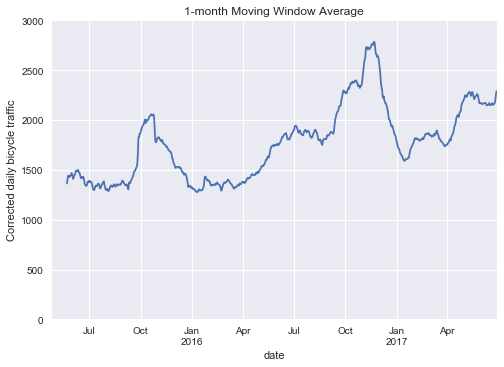

In [21]:
daily['weather_corrected'].rolling(window = 30).mean().plot()
#daily['count'].rolling(window = 30).mean().plot(color = 'green')
plt.ylabel('Corrected daily bicycle traffic')
plt.title('1-month Moving Window Average')
plt.ylim(0,3000);

### Accounting for increase in Indego stations and overall increase/decrease of riders over time

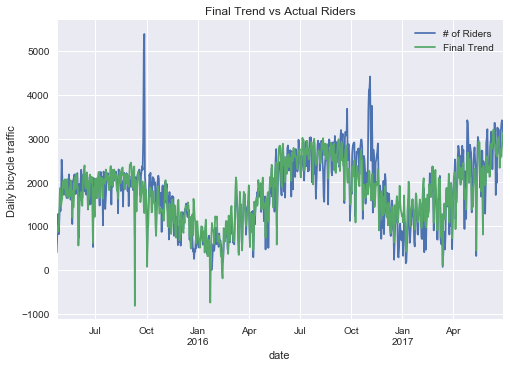

In [22]:
#add the day index to account for overall increase/decrease in riders over time
daily['daycount'] = np.arange(len(daily))

columns = days + ['daylight', 'AWND', 'TMIN', 'TMAX', 'PRCP', 'daycount','num_stations']

#creates linear model using day of week and weather factors to predict number of riders
X = daily[columns]
y = daily['count']
final_model = LinearRegression().fit(X, y)
daily['final_trend'] = final_model.predict(X)
# Plot the overall trend
daily[['count', 'final_trend']].plot()
plt.title('Final Trend vs Actual Riders')
plt.legend(['# of Riders','Final Trend'])
plt.ylabel('Daily bicycle traffic');

De-trend the data again

rms = 439


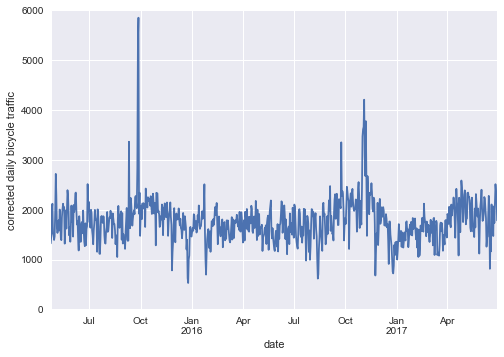

In [23]:
daily['final_corrected'] = daily['count'] - daily['final_trend'] + daily['final_trend'].mean()
print("rms = {0:.0f}".format(np.std(daily['final_corrected'])))
daily['final_corrected'].plot()
plt.ylabel('corrected daily bicycle traffic')
plt.ylim(0,6000);

The rms is reduced again but there is still variation that's not account for. One hypothesis is that the weather has a non-linear effect on people's decision to go out and ride a bike. For example, a warm day in the winter would cause a lot of people to go out and ride, whereas a warm day in the summer is the norm and may not have as strong of an effect on ridership.

Now that the final model has been created, let's plot it next to the actual number of riders.

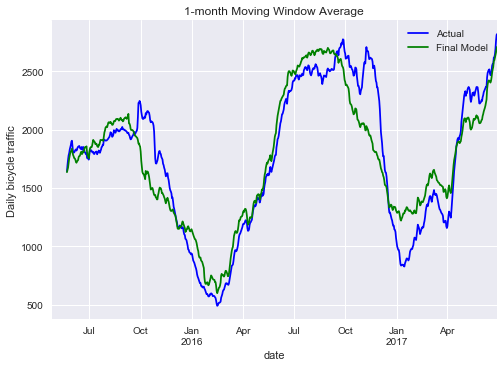

In [24]:
daily['count'].rolling(window = 30).mean().plot(color = 'blue')
daily['final_trend'].rolling(window = 30).mean().plot(color='green')
plt.ylabel('Daily bicycle traffic')
plt.title('1-month Moving Window Average')
plt.legend(['Actual', 'Final Model']);

- The model under-predicts ridership in both falls of 2015 and 2016. This is due to the large increase in riders from the Pope visit in 2015 and the SEPTA strike in 2016


### Conclusions
Now let's use the final model to see how much bike sharing is really increasing in Philadelphia.

In [25]:
vy = np.sum((y - daily['final_trend']) ** 2) / len(y)
X2 = np.hstack([X, np.ones((X.shape[0], 1))])
C = vy * np.linalg.inv(np.dot(X2.T, X2))
var = C.diagonal()

In [26]:
ind = columns.index('PRCP')
slope = final_model.coef_[ind]
error = np.sqrt(var[ind])
print("{0:.0f} +/- {1:.0f} daily riders lost per inch of rain".format(-slope, error))

588 +/- 49 daily riders lost per inch of rain


In [27]:
ind1, ind2 = columns.index('TMIN'), columns.index('TMAX')
slope = final_model.coef_[ind1] + final_model.coef_[ind2]
error = np.sqrt(var[ind1] + var[ind2])
print('{0:.0f} +/- {1:.0f} daily riders per ten degrees Fahrenheit'.format(10 * slope, 10 * error))

295 +/- 41 daily riders per ten degrees Fahrenheit


As expected, an increase in precipitation leads to less riders and an higher temperatures lead to an increase in riders. 

In [28]:
ind = columns.index('daylight')
slope = final_model.coef_[ind]
error = np.sqrt(var[ind])
print("{0:.0f} +/- {1:.0f} daily riders gained per hour of daylight".format(slope, error))

6 +/- 12 daily riders gained per hour of daylight


Interestingly, hours of daylight doesn't have a large impact on ridership. This could be because of a few reasons:
- Hours of daylight is heavily correlated with temperature
- As seen in my Exploratory Analysis notebook, many riders appear to use the service to commute so they would be less likely to be affected by daylight

In [29]:
ind = columns.index('num_stations')
slope = final_model.coef_[ind]
error = np.sqrt(var[ind])
print("{0:.2f} +/- {1:.2f} new riders per new station".format(slope, error))

16.23 +/- 2.54 new riders per new station


It's good to see that Indego's investments in new stations does lead to more people riding

In [30]:
ind = columns.index('daycount')
slope = final_model.coef_[ind]
error = np.sqrt(var[ind])
print("{0:.2f} +/- {1:.2f} new riders per day".format(slope, error))
print("{0:.1f} +/- {1:.1f} new riders per week".format(7 * slope, 7 * error))
print("annual change: ({0:.0f} +/- {1:.0f})%".format(100 * 365 * slope / daily['count'].mean(),
                                                    100 * 365 * error / daily['count'].mean()))

0.08 +/- 0.19 new riders per day
0.5 +/- 1.3 new riders per week
annual change: (2 +/- 4)%


Finally, we see that after correcting for all of the trends above there is only a slight (if any) increase in ridership in the 2+ years Indego has been operating in Philadelphia